In [308]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage import exposure

import os
from tqdm import tqdm
import pickle

import imutils
from imutils.contours import sort_contours
from random import randint

In [309]:
path = './ktm'
# menampung array untuk gambar
# plates = []

# lst = os.listdir(path)
# lst.sort()
# for img in tqdm(lst):  # kita ambil semua isi dalam folder
#   try:
#     img_array = cv.imread(os.path.join(path, img))  # kita baca image nya
#     plates.append(img_array)
#   except Exception as e:
#     pass

In [310]:
def toRGB(img):
  return cv.cvtColor(img, cv.COLOR_BGR2RGB)

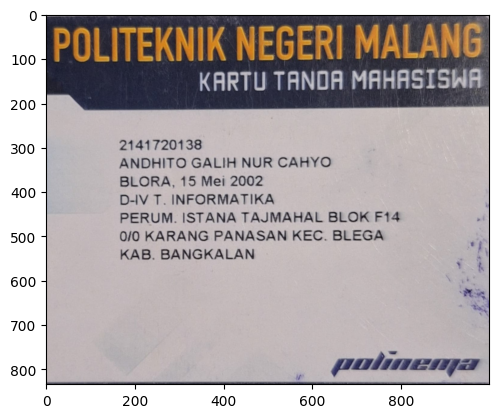

In [311]:
imgKTM = cv.imread('./ktm/ktm11.jpg')

w, h, c = imgKTM.shape
width, height = w/h*1000, 1000
imgKTM = cv.resize(imgKTM, (int(height), int(width)))

plt.imshow(toRGB(imgKTM))
plt.show()

In [312]:
def cv2_imshow(img, title='Image', size=None):
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  if size is not None:
    plt.figure(figsize=size)
  plt.imshow(img)
  plt.title(title)
  plt.show()

In [313]:
def detect_contour(edged): # contour max
  contours, _ = cv.findContours(edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv.contourArea, reverse=True)
  return max(contours, key=cv.contourArea)

In [314]:
def reflection(img): # reflection image remover
  hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  h, s, v = cv.split(hsv_image)

  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  v = clahe.apply(v)

  hsv_image = cv.merge([h, s, v])
  return cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)

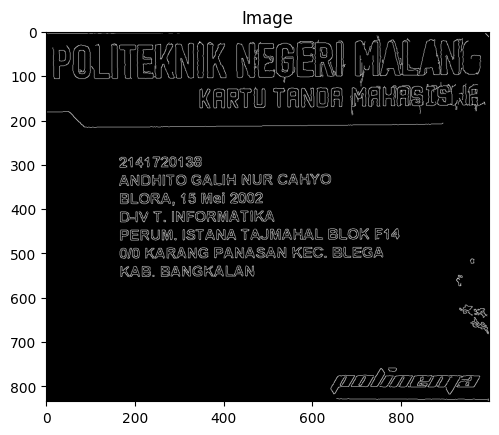

In [315]:
image = imgKTM.copy()
ktm = image.copy()

image = reflection(image)
inverted_img = cv.bitwise_not(image)
gray = cv.cvtColor(inverted_img, cv.COLOR_BGR2GRAY)
gray1 = cv.bilateralFilter(gray.copy(), 19, 19, 17)
# gray1 = cv.medianBlur(gray1, 5)
edged = cv.Canny(gray1, 60, 400)
# edged = cv.dilate(edged, np.ones((17, 17), dtype=np.int8))
cv2_imshow(edged)

In [316]:
# Define function for contour detection
def find_contours(img):
  conts = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts

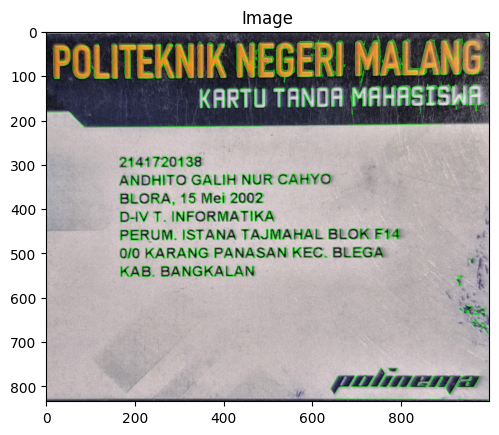

In [317]:
img_asli = ktm.copy()

contours = find_contours(edged.copy())

cv.drawContours(image, contours, -1, (0, 255, 0), 1)



cv2_imshow(image)

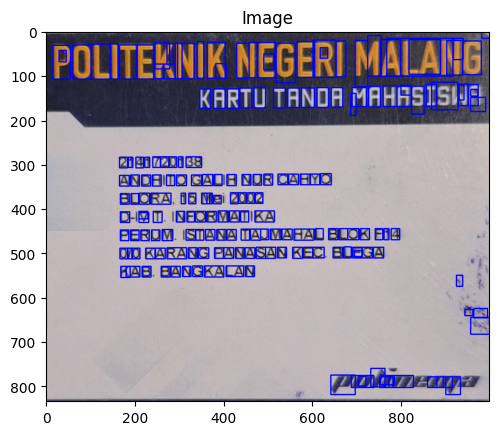

In [318]:
crop = img_asli.copy()

min_w, max_w = 8, 160
min_h, max_h = 14, 140
num = 0
for c in contours:
  (x, y, w, h) = cv.boundingRect(c)  # find bounding box based on contour
  # if pixel follow this rule, it consider as char
  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    roi = img_asli[y:y+h, x:x+w]  # get region of interest for char
    # thresh = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    # cv2_imshow(roi, size=(0.6,0.5))  # check
    cv.imwrite(f'./dataset-galih/char_{num}-glh.jpg', roi)  # save char
    num += 1
    # Build bounding box on original image
    cv.rectangle(crop, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Show bounding box on original image
cv2_imshow(crop)